# Environment

In [1]:
!git clone https://github.com/cuongtv312/marl-delivery.git marl_delivery

fatal: destination path 'marl_delivery' already exists and is not an empty directory.


In [2]:
from marl_delivery.env import Environment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical
import numpy as np
import random
import os
from sklearn.preprocessing import LabelEncoder # For action conversion
import matplotlib.pyplot as plt

SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Convert Observation - Spatial Features

In [3]:
def convert_observation(env_state_dict, persistent_packages_for_env, current_robot_idx):
    """
    Tạo observation dạng multi-channel cho 1 robot.
    Channels:
        0: Obstacle map
        1: Vị trí robot hiện tại
        2: Vị trí các robot khác
        3: Vị trí start của các package 'waiting'
        4: Vị trí target của các package 'active' (waiting hoặc in_transit)
        5: Vị trí target của package mà robot này đang cầm (nếu có)
    """
    num_channels = 6
    grid = np.array(env_state_dict['map'], dtype=np.float32)
    n_rows, n_cols = grid.shape
    obs = np.zeros((num_channels, n_rows, n_cols), dtype=np.float32)

    # Channel 0: Obstacle map
    obs[0] = grid

    # Kiểm tra robot index hợp lệ
    if not (0 <= current_robot_idx < len(env_state_dict['robots'])):
        return obs

    robots = env_state_dict['robots']
    my_r, my_c, my_pkg = [int(x) for x in robots[current_robot_idx]]
    my_r -= 1; my_c -= 1  # 0-indexed

    # Channel 1: Vị trí robot hiện tại
    if 0 <= my_r < n_rows and 0 <= my_c < n_cols:
        obs[1, my_r, my_c] = 1.0

    # Channel 2: Vị trí các robot khác
    for i, (r, c, _) in enumerate(robots):
        if i == current_robot_idx: continue
        r, c = int(r)-1, int(c)-1
        if 0 <= r < n_rows and 0 <= c < n_cols:
            obs[2, r, c] = 1.0

    # Channel 3, 4, 5: Package info
    t = env_state_dict['time_step']
    for pkg_id, pkg in persistent_packages_for_env.items():
        # Channel 3: Start pos của package 'waiting'
        if pkg['status'] == 'waiting' and pkg['start_time'] <= t:
            sr, sc = pkg['start_pos']
            if 0 <= sr < n_rows and 0 <= sc < n_cols:
                obs[3, sr, sc] = 1.0
        # Channel 4: Target pos của package 'active'
        if (pkg['status'] == 'waiting' and pkg['start_time'] <= t) or pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            if 0 <= tr < n_rows and 0 <= tc < n_cols:
                obs[4, tr, tc] = 1.0

    # Channel 5: Target pos của package mà robot này đang cầm
    if my_pkg != 0 and my_pkg in persistent_packages_for_env:
        pkg = persistent_packages_for_env[my_pkg]
        if pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            if 0 <= tr < n_rows and 0 <= tc < n_cols:
                obs[5, tr, tc] = 1.0

    return obs

# Generate Vector Features - Non Spatial Features

In [4]:
def generate_vector_features(env_state_dict, persistent_packages_for_env, current_robot_idx,
                            max_time_steps,
                            max_other_robots_to_observe, max_packages_to_observe):
    """
    Sinh vector đặc trưng phi không gian cho 1 robot.
    """
    n_rows, n_cols = np.array(env_state_dict['map'], dtype=np.float32).shape
    robots = env_state_dict['robots']
    t = env_state_dict['time_step']

    # Định nghĩa số chiều cho từng phần
    my_feat = 6
    other_feat = 5
    pkg_feat = 5
    time_feat = 1

    # Nếu robot index không hợp lệ, trả về vector 0
    total_len = my_feat + max_other_robots_to_observe * other_feat + max_packages_to_observe * pkg_feat + time_feat
    if not (0 <= current_robot_idx < len(robots)):
        return np.zeros(total_len, dtype=np.float32)

    # 1. Thông tin robot hiện tại
    my_r, my_c, my_pkg = [int(x) for x in robots[current_robot_idx]]
    my_r -= 1; my_c -= 1
    is_carrying = 1.0 if my_pkg != 0 else 0.0
    feat = [
        my_r / n_rows,
        my_c / n_cols,
        is_carrying
    ]
    # Nếu đang cầm package
    if is_carrying and my_pkg in persistent_packages_for_env:
        pkg = persistent_packages_for_env[my_pkg]
        if pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            deadline = pkg['deadline']
            feat += [
                (tr - my_r) / n_rows,
                (tc - my_c) / n_cols,
                max(0, deadline - t) / max_time_steps if max_time_steps > 0 else 0.0
            ]
        else:
            feat += [0.0, 0.0, 0.0]
    else:
        feat += [0.0, 0.0, 0.0]

    # 2. Thông tin các robot khác
    others = []
    for i, (r, c, pkg_id) in enumerate(robots):
        if i == current_robot_idx: continue
        r, c, pkg_id = int(r)-1, int(c)-1, int(pkg_id)
        is_c = 1.0 if pkg_id != 0 else 0.0
        other = [
            (r - my_r) / n_rows,
            (c - my_c) / n_cols,
            is_c
        ]
        if is_c and pkg_id in persistent_packages_for_env:
            pkg = persistent_packages_for_env[pkg_id]
            if pkg['status'] == 'in_transit':
                tr, tc = pkg['target_pos']
                other += [
                    (tr - r) / n_rows,
                    (tc - c) / n_cols
                ]
            else:
                other += [0.0, 0.0]
        else:
            other += [0.0, 0.0]
        others.append(other)
    # Sắp xếp theo khoảng cách tới robot hiện tại
    others.sort(key=lambda x: x[0]**2 + x[1]**2)
    for i in range(max_other_robots_to_observe):
        feat += others[i] if i < len(others) else [0.0]*other_feat

    # 3. Thông tin các package 'waiting'
    pkgs = []
    for pkg_id, pkg in persistent_packages_for_env.items():
        if pkg['status'] == 'waiting' and pkg['start_time'] <= t:
            sr, sc = pkg['start_pos']
            tr, tc = pkg['target_pos']
            deadline = pkg['deadline']
            pkgs.append([
                (sr - my_r) / n_rows,
                (sc - my_c) / n_cols,
                (tr - my_r) / n_rows,
                (tc - my_c) / n_cols,
                max(0, deadline - t) / max_time_steps if max_time_steps > 0 else 0.0
            ])
    # Sắp xếp theo deadline và khoảng cách
    pkgs.sort(key=lambda x: (x[4], x[0]**2 + x[1]**2))
    for i in range(max_packages_to_observe):
        feat += pkgs[i] if i < len(pkgs) else [0.0]*pkg_feat

    # 4. Thời gian toàn cục (chuẩn hóa)
    feat.append(t / max_time_steps if max_time_steps > 0 else 0.0)

    return np.array(feat, dtype=np.float32)

# Convert Global State

In [5]:
def convert_global_state(env_state_dict, persistent_packages_for_env,
                                max_time_steps,
                                max_robots_in_state=100, max_packages_in_state=100):
    """
    Sinh global state (spatial + vector) cho Critic.
    """
    # --- Spatial ---
    num_map_channels = 4
    n_rows, n_cols = np.array(env_state_dict['map'], dtype=np.float32).shape
    
    global_map = np.zeros((num_map_channels, n_rows, n_cols), dtype=np.float32)
    global_map[0] = np.array(env_state_dict['map'], dtype=np.float32)  # Obstacles

    # Channel 1: All robot positions
    for r, c, _ in env_state_dict['robots']:
        r0, c0 = int(r)-1, int(c)-1
        if 0 <= r0 < n_rows and 0 <= c0 < n_cols:
            global_map[1, r0, c0] = 1.0

    t = env_state_dict['time_step']
    for pkg in persistent_packages_for_env.values():
        # Channel 2: waiting package start
        if pkg['status'] == 'waiting' and pkg['start_time'] <= t:
            sr, sc = pkg['start_pos']
            if 0 <= sr < n_rows and 0 <= sc < n_cols:
                global_map[2, sr, sc] = 1.0
        # Channel 3: active package target
        if (pkg['status'] == 'waiting' and pkg['start_time'] <= t) or pkg['status'] == 'in_transit':
            tr, tc = pkg['target_pos']
            if 0 <= tr < n_rows and 0 <= tc < n_cols:
                global_map[3, tr, tc] = 1.0

    # --- Vector ---
    vec = []
    # 1. Robots (padded)
    for i in range(max_robots_in_state):
        if i < len(env_state_dict['robots']):
            r, c, carried = env_state_dict['robots'][i]
            r0, c0 = int(r)-1, int(c)-1
            is_carrying = 1.0 if carried != 0 else 0.0
            vec += [r0/n_rows, c0/n_cols, is_carrying]
            if is_carrying and carried in persistent_packages_for_env:
                pkg = persistent_packages_for_env[carried]
                if pkg['status'] == 'in_transit':
                    tr, tc = pkg['target_pos']
                    deadline = pkg['deadline']
                    vec += [tr/n_rows, tc/n_cols, max(0, deadline-t)/max_time_steps if max_time_steps > 0 else 0.0]
                else:
                    vec += [0.0, 0.0, 0.0]
            else:
                vec += [0.0, 0.0, 0.0]
        else:
            vec += [0.0]*6

    # 2. Active packages (padded)
    pkgs = []
    for pkg in persistent_packages_for_env.values():
        is_active = (pkg['status'] == 'waiting' and pkg['start_time'] <= t) or pkg['status'] == 'in_transit'
        if is_active:
            pkgs.append(pkg)
    pkgs = sorted(pkgs, key=lambda p: p['id'])
    for i in range(max_packages_in_state):
        if i < len(pkgs):
            pkg = pkgs[i]
            sr, sc = pkg['start_pos']
            tr, tc = pkg['target_pos']
            deadline = pkg['deadline']
            status = pkg['status']
            # start pos (nếu waiting), target pos, deadline, status, carrier_id_norm
            if status == 'waiting':
                vec += [sr/n_rows, sc/n_cols]
            else:
                vec += [0.0, 0.0]
            vec += [tr/n_rows, tc/n_cols]
            vec += [max(0, deadline-t)/max_time_steps if max_time_steps > 0 else 0.0]
            vec += [0.0 if status == 'waiting' else 1.0]
            carrier_id_norm = -1.0
            if status == 'in_transit':
                for ridx, rdata in enumerate(env_state_dict['robots']):
                    if rdata[2] == pkg['id']:
                        carrier_id_norm = ridx/(max_robots_in_state-1) if max_robots_in_state > 1 else 0.0
                        break
            vec += [carrier_id_norm]
        else:
            vec += [0.0]*7

    # 3. Global time
    vec.append(t/max_time_steps if max_time_steps > 0 else 0.0)
    return global_map, np.array(vec, dtype=np.float32)

# Visualize Features

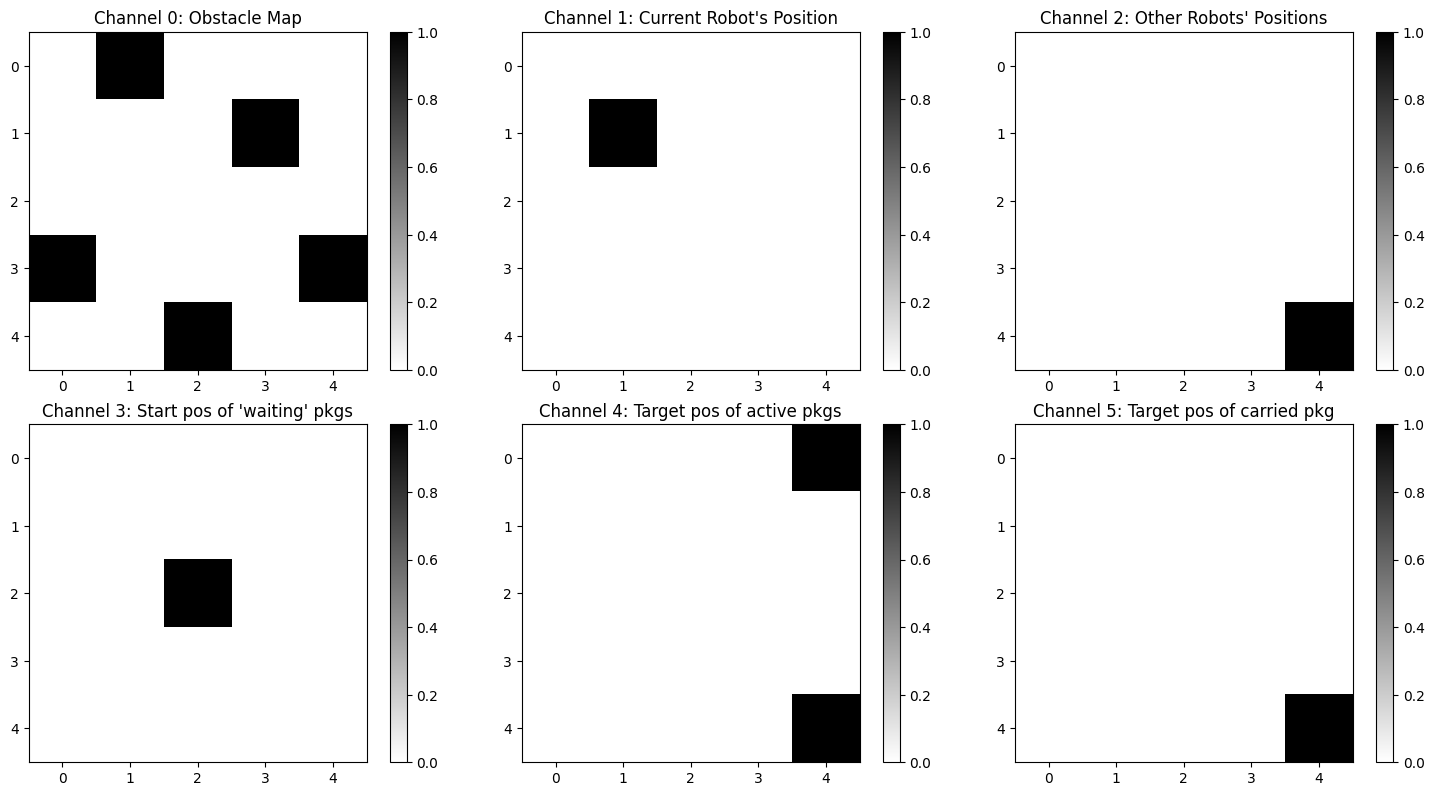

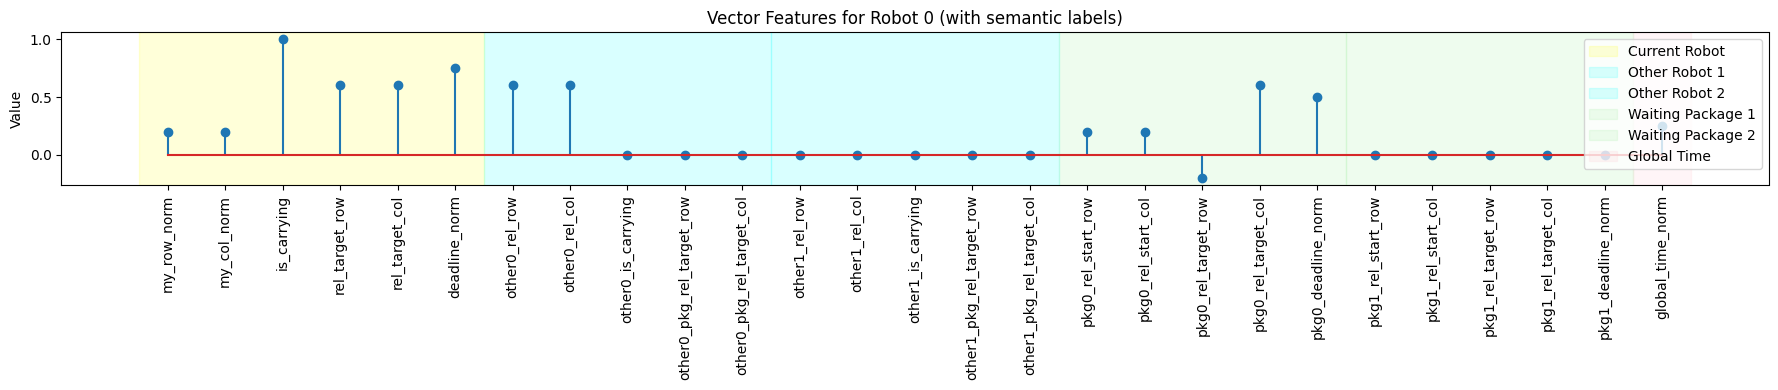

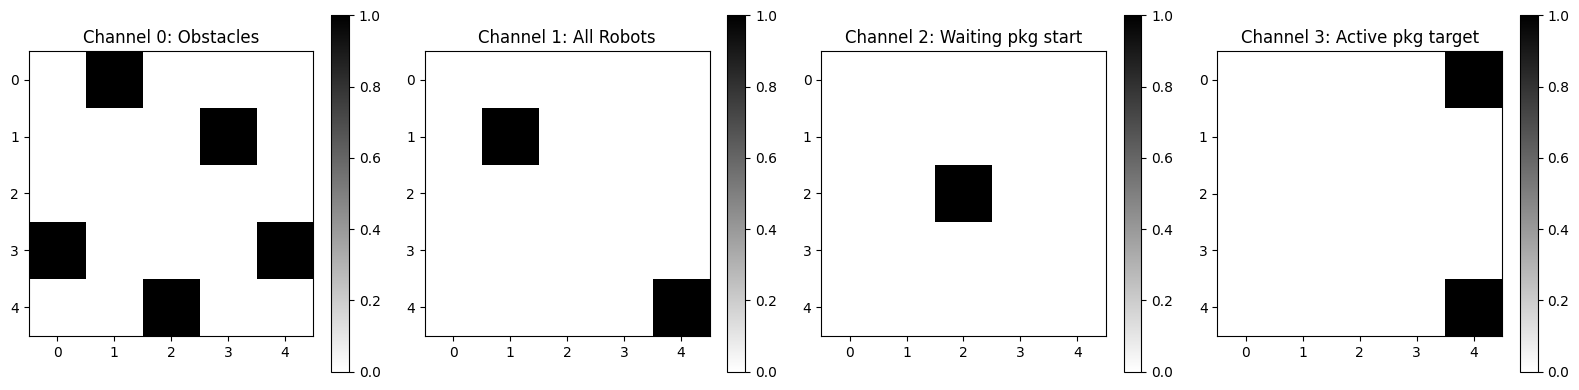

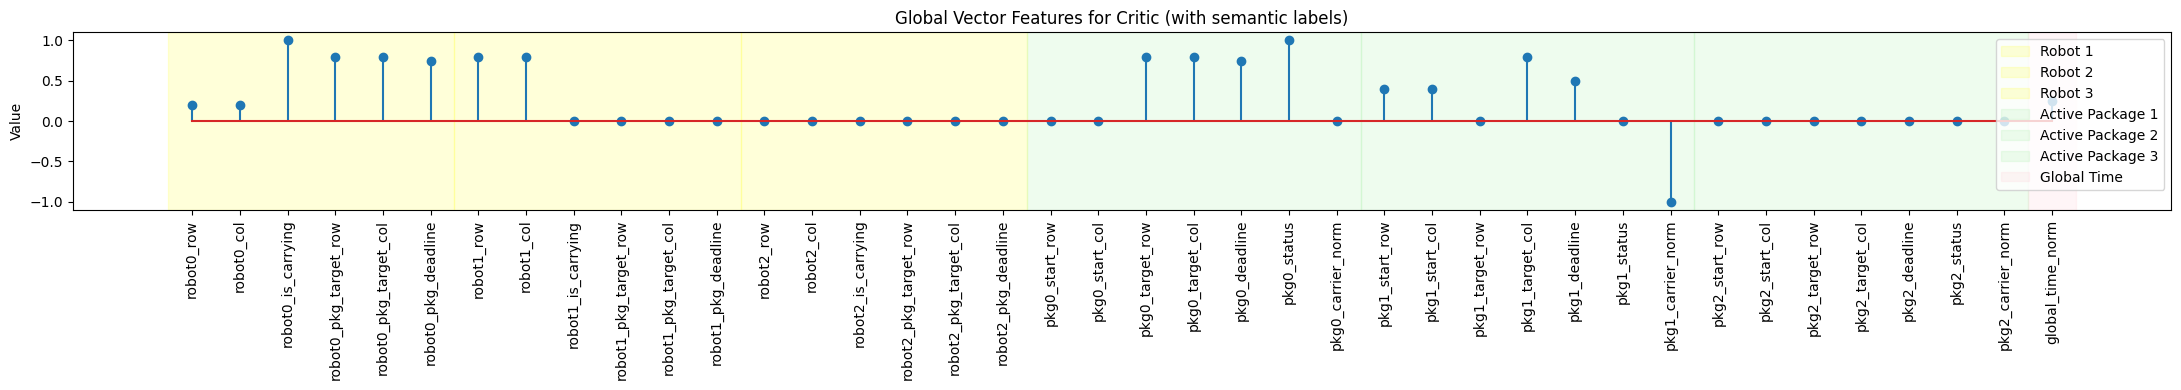

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy env_state_dict và persistent_packages_for_env
env_state_dict = {
    'map': np.array([
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [0, 0, 1, 0, 0]
    ], dtype=np.float32),
    'robots': [
        (2, 2, 1),  # Robot 0 at (1,1), carrying package 1 (all 1-indexed)
        (5, 5, 0),  # Robot 1 at (4,4), not carrying
    ],
    'time_step': 5
}
persistent_packages_for_env = {
    1: {
        'id': 1,
        'start_pos': (0, 0),      # 0-indexed
        'target_pos': (4, 4),     # 0-indexed
        'start_time': 0,
        'deadline': 20,
        'status': 'in_transit'
    },
    2: {
        'id': 2,
        'start_pos': (2, 2),
        'target_pos': (0, 4),
        'start_time': 3,
        'deadline': 15,
        'status': 'waiting'
    }
}

# --- 1. Visualize convert_observation ---
obs = convert_observation(env_state_dict, persistent_packages_for_env, current_robot_idx=0)
channel_names = [
    "Obstacle Map",
    "Current Robot's Position",
    "Other Robots' Positions",
    "Start pos of 'waiting' pkgs",
    "Target pos of active pkgs",
    "Target pos of carried pkg"
]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(6):
    ax = axes[i // 3, i % 3]
    im = ax.imshow(obs[i], cmap='gray_r', vmin=0, vmax=1)
    ax.set_title(f"Channel {i}: {channel_names[i]}")
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# --- 2. Visualize generate_vector_features ---
max_time_steps = 20
max_other_robots_to_observe = 2
max_packages_to_observe = 2
vec = generate_vector_features(
    env_state_dict, persistent_packages_for_env, current_robot_idx=0,
    max_time_steps=max_time_steps,
    max_other_robots_to_observe=max_other_robots_to_observe,
    max_packages_to_observe=max_packages_to_observe
)
my_feat = 6
other_feat = 5
pkg_feat = 5
time_feat = 1
idx = 0
labels = []
sections = []
labels += [
    "my_row_norm", "my_col_norm", "is_carrying",
    "rel_target_row", "rel_target_col", "deadline_norm"
]
sections.append((idx, idx+my_feat, "Current Robot"))
idx += my_feat
for i in range(max_other_robots_to_observe):
    labels += [
        f"other{i}_rel_row", f"other{i}_rel_col", f"other{i}_is_carrying",
        f"other{i}_pkg_rel_target_row", f"other{i}_pkg_rel_target_col"
    ]
    sections.append((idx, idx+other_feat, f"Other Robot {i+1}"))
    idx += other_feat
for i in range(max_packages_to_observe):
    labels += [
        f"pkg{i}_rel_start_row", f"pkg{i}_rel_start_col",
        f"pkg{i}_rel_target_row", f"pkg{i}_rel_target_col",
        f"pkg{i}_deadline_norm"
    ]
    sections.append((idx, idx+pkg_feat, f"Waiting Package {i+1}"))
    idx += pkg_feat
labels.append("global_time_norm")
sections.append((idx, idx+time_feat, "Global Time"))

fig, ax = plt.subplots(figsize=(18, 4))
ax.stem(range(len(vec)), vec)
ax.set_xticks(range(len(vec)))
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_ylabel("Value")
ax.set_title("Vector Features for Robot 0 (with semantic labels)")
for start, end, name in sections:
    ax.axvspan(start-0.5, end-0.5, color='yellow' if "Current" in name else
               'cyan' if "Other" in name else
               'lightgreen' if "Package" in name else
               'pink', alpha=0.15, label=name)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), loc='upper right')
plt.tight_layout()
plt.show()

# --- 3. Visualize get_global_state_for_critic ---
n_rows, n_cols = 5, 5
max_simulation_time = 20
max_robots_in_state = 3
max_packages_in_state = 3

global_map, global_vec = convert_global_state(
    env_state_dict, persistent_packages_for_env,
    max_simulation_time,
    max_robots_in_state, max_packages_in_state
)

map_names = [
    "Obstacles", "All Robots", "Waiting pkg start", "Active pkg target"
]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ax = axes[i]
    im = ax.imshow(global_map[i], cmap='gray_r', vmin=0, vmax=1)
    ax.set_title(f"Channel {i}: {map_names[i]}")
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

robot_feat = 6
pkg_feat = 7
time_feat = 1
idx = 0
labels = []
sections = []
for i in range(max_robots_in_state):
    labels += [
        f"robot{i}_row", f"robot{i}_col", f"robot{i}_is_carrying",
        f"robot{i}_pkg_target_row", f"robot{i}_pkg_target_col", f"robot{i}_pkg_deadline"
    ]
    sections.append((idx, idx+robot_feat, f"Robot {i+1}"))
    idx += robot_feat
for i in range(max_packages_in_state):
    labels += [
        f"pkg{i}_start_row", f"pkg{i}_start_col",
        f"pkg{i}_target_row", f"pkg{i}_target_col",
        f"pkg{i}_deadline", f"pkg{i}_status", f"pkg{i}_carrier_norm"
    ]
    sections.append((idx, idx+pkg_feat, f"Active Package {i+1}"))
    idx += pkg_feat
labels.append("global_time_norm")
sections.append((idx, idx+time_feat, "Global Time"))

fig, ax = plt.subplots(figsize=(22, 4))
ax.stem(range(len(global_vec)), global_vec)
ax.set_xticks(range(len(global_vec)))
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_ylabel("Value")
ax.set_title("Global Vector Features for Critic (with semantic labels)")
for start, end, name in sections:
    ax.axvspan(start-0.5, end-0.5, color='yellow' if "Robot" in name else
               'lightgreen' if "Package" in name else
               'pink', alpha=0.15, label=name)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), loc='upper right')
plt.tight_layout()
plt.show()

# Args

In [7]:
class Args:
    def __init__(self, config_path="QMIX/config.yaml"):
        # Environment parameters
        self.n_agents = 5                   # Number of agents in the environment
        self.n_packages = 20                # Number of packages in the environment
        self.max_time_steps_env = 100      # Maximum time steps per environment episode
        self.render = False                  # Whether to render the environment
        self.delivery_reward = 10          # Reward for delivering a package
        self.delay_reward = 1             # Reward for delaying a package
        self.move_cost = -0.01               # Cost for moving
        self.map_file = "marl_delivery/map1.txt"

        # Network architecture parameters
        self.rnn_hidden_dim = 64            # Hidden dimension for the RNN in agent networks
        self.mixing_embed_dim = 32          # Embedding dimension for the mixing network
        self.hypernet_embed = 64            # Embedding dimension for the hypernetwork

        # Optimization parameters
        self.lr = 0.0005                    # Learning rate for the optimizer
        self.optim_alpha = 0.99             # Alpha parameter for RMSprop optimizer
        self.grad_norm_clip = 10            # Gradient norm clipping value

        # Training and target update parameters
        self.gamma = 0.99                   # Discount factor for future rewards
        self.target_update_type = "hard"    # Type of target network update ("hard" or "soft")
        self.target_update_interval = 200   # Interval (in steps) for hard target updates
        self.tau = 0.005                    # Soft update coefficient (if using soft updates)
        self.hard_target_update = True      # Whether to use hard target updates

        # Replay buffer and training loop parameters
        self.num_parallel_envs = 4          # Number of parallel environments for data collection
        self.buffer_size = 1000             # Maximum size of the replay buffer
        self.batch_size = 64              # Batch size for training
        self.episode_limit = 1000            # Maximum steps per episode
        self.min_timesteps_to_train = 1000  # Minimum timesteps before training starts
        self.min_buffer_size_to_train = 50 # Minimum buffer size before training starts
        self.max_training_iterations = 1000 # Maximum number of training iterations
        self.max_total_timesteps = 500000   # Maximum total timesteps for training

        # Exploration parameters
        self.epsilon_start = 1.0            # Initial epsilon for epsilon-greedy exploration
        self.epsilon_finish = 0.05          # Final epsilon value
        self.epsilon_anneal_time = 500000   # Number of timesteps over which to anneal epsilon
        self.use_epsilon_greedy = True      # Whether to use epsilon-greedy exploration

        # Training step parameters
        self.num_train_steps_per_iteration = 8 # Number of training steps per iteration

        # Logging and saving
        self.log_interval = 10              # Interval (in iterations) for logging
        self.save_model_interval = 100      # Interval (in iterations) for saving the model

        # Environment observation parameters
        self.max_other_robots_to_observe = 4    # Max number of other robots each agent can observe
        self.max_packages_to_observe = 5        # Max number of packages each agent can observe
        self.max_robots_in_state = 10           # Max number of robots in the state representation
        self.max_packages_in_state = 20         # Max number of packages in the state representation

        # Miscellaneous
        self.seed = 42                      # Random seed for reproducibility

        # Model loading
        self.load_model_path = None         # Path to load a pre-trained model (if any)
        self.load_model_episode = 0         # Episode number to load the model from
            
        self.use_cuda = torch.cuda.is_available()

In [8]:
def save_qmix_model(actor, critic, path_prefix="models/qmix"):
    abs_prefix = os.path.abspath(path_prefix)
    dir_name = os.path.dirname(abs_prefix)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    torch.save(actor.state_dict(), f"{abs_prefix}_agent.pt")
    torch.save(critic.state_dict(), f"{abs_prefix}_mixer.pt")
    print(f"QMIX models saved with prefix {path_prefix}")
def load_qmix_model(actor, critic, path_prefix="models/qmix", device="cpu"):
    actor_path = f"{path_prefix}_agent.pt"
    critic_path = f"{path_prefix}_mixer.pt"
    if os.path.exists(actor_path) and os.path.exists(critic_path):
        actor.load_state_dict(torch.load(actor_path, map_location=device))
        critic.load_state_dict(torch.load(critic_path, map_location=device))
        print(f"QMIX models loaded from prefix {path_prefix}")
        return True
    print(f"Could not find QMIX models at prefix {path_prefix}")
    return False

# Replay Buffer

In [9]:
class ReplayBuffer:
    def __init__(self, capacity, episode_limit, n_agents,
                 spatial_obs_shape, vector_obs_dim,
                 global_spatial_state_shape, global_vector_state_dim,
                 n_actions, args):
        self.capacity = capacity
        self.episode_limit = episode_limit
        self.n_agents = n_agents
        self.n_actions = n_actions
        self.args = args

        # Shapes
        self.spatial_obs_shape = spatial_obs_shape # (C_obs, H, W)
        self.vector_obs_dim = vector_obs_dim
        self.global_spatial_state_shape = global_spatial_state_shape # (C_global, H, W)
        self.global_vector_state_dim = global_vector_state_dim

        # Initialize buffers
        self.buffer_spatial_obs = np.zeros((capacity, episode_limit, n_agents, *spatial_obs_shape), dtype=np.float32)
        self.buffer_vector_obs = np.zeros((capacity, episode_limit, n_agents, vector_obs_dim), dtype=np.float32)
        
        self.buffer_global_spatial_state = np.zeros((capacity, episode_limit, *global_spatial_state_shape), dtype=np.float32)
        self.buffer_global_vector_state = np.zeros((capacity, episode_limit, global_vector_state_dim), dtype=np.float32)
        
        self.buffer_actions = np.zeros((capacity, episode_limit, n_agents, 1), dtype=np.int64)
        self.buffer_rewards = np.zeros((capacity, episode_limit, 1), dtype=np.float32) # Global reward
        
        self.buffer_next_spatial_obs = np.zeros((capacity, episode_limit, n_agents, *spatial_obs_shape), dtype=np.float32)
        self.buffer_next_vector_obs = np.zeros((capacity, episode_limit, n_agents, vector_obs_dim), dtype=np.float32)

        self.buffer_next_global_spatial_state = np.zeros((capacity, episode_limit, *global_spatial_state_shape), dtype=np.float32)
        self.buffer_next_global_vector_state = np.zeros((capacity, episode_limit, global_vector_state_dim), dtype=np.float32)
        
        self.buffer_avail_actions = np.zeros((capacity, episode_limit, n_agents, n_actions), dtype=np.bool_)
        self.buffer_next_avail_actions = np.zeros((capacity, episode_limit, n_agents, n_actions), dtype=np.bool_)
        
        self.buffer_terminated = np.zeros((capacity, episode_limit, 1), dtype=np.bool_)
        # Padded is True if the step is beyond actual episode length
        self.buffer_padded = np.ones((capacity, episode_limit, 1), dtype=np.bool_)
        self.buffer_actual_episode_len = np.zeros((capacity,), dtype=np.int32)


        self.current_size = 0
        self.current_idx = 0

    def add_episode_data(self, episode_transitions):
        """
        Thêm một episode hoàn chỉnh vào buffer.
        episode_transitions: list các dictionary, mỗi dict chứa một transition.
        Keys: "so", "vo", "gs", "gv", "u", "r", "so_next", "vo_next",
              "gs_next", "gv_next", "avail_u", "avail_u_next", "terminated"
        """
        episode_len = len(episode_transitions)
        if episode_len == 0 or episode_len > self.episode_limit:
            print(f"Warning: Episode length {episode_len} is 0 or exceeds limit {self.episode_limit}. Skipping.")
            return

        idx = self.current_idx
        self.buffer_actual_episode_len[idx] = episode_len

        # Reset padding for this episode slot first
        self.buffer_padded[idx] = True 

        for t_idx, trans in enumerate(episode_transitions):
            self.buffer_spatial_obs[idx, t_idx] = trans["so"]
            self.buffer_vector_obs[idx, t_idx] = trans["vo"]
            self.buffer_global_spatial_state[idx, t_idx] = trans["gs"]
            self.buffer_global_vector_state[idx, t_idx] = trans["gv"]
            self.buffer_actions[idx, t_idx] = trans["u"].reshape(self.n_agents, 1) # Ensure shape (N,1)
            self.buffer_rewards[idx, t_idx] = trans["r"]
            self.buffer_next_spatial_obs[idx, t_idx] = trans["so_next"]
            self.buffer_next_vector_obs[idx, t_idx] = trans["vo_next"]
            self.buffer_next_global_spatial_state[idx, t_idx] = trans["gs_next"]
            self.buffer_next_global_vector_state[idx, t_idx] = trans["gv_next"]
            self.buffer_avail_actions[idx, t_idx] = trans["avail_u"]
            self.buffer_next_avail_actions[idx, t_idx] = trans["avail_u_next"]
            self.buffer_terminated[idx, t_idx] = trans["terminated"]
            self.buffer_padded[idx, t_idx] = False # Mark as not padded

        self.current_idx = (self.current_idx + 1) % self.capacity
        if self.current_size < self.capacity:
            self.current_size += 1

    def sample(self):
        if self.current_size < self.args.batch_size:
             raise ValueError(f"Replay buffer has {self.current_size} episodes, less than batch size {self.args.batch_size}. Cannot sample.")


        indices = np.random.choice(self.current_size, self.args.batch_size, replace=False)
        device = torch.device("cuda" if self.args.use_cuda else "cpu")

        batch = {
            'so': torch.tensor(self.buffer_spatial_obs[indices], dtype=torch.float32, device=device),
            'vo': torch.tensor(self.buffer_vector_obs[indices], dtype=torch.float32, device=device),
            'gs': torch.tensor(self.buffer_global_spatial_state[indices], dtype=torch.float32, device=device),
            'gv': torch.tensor(self.buffer_global_vector_state[indices], dtype=torch.float32, device=device),
            'u': torch.tensor(self.buffer_actions[indices], dtype=torch.long, device=device),
            'r': torch.tensor(self.buffer_rewards[indices], dtype=torch.float32, device=device),
            'so_next': torch.tensor(self.buffer_next_spatial_obs[indices], dtype=torch.float32, device=device),
            'vo_next': torch.tensor(self.buffer_next_vector_obs[indices], dtype=torch.float32, device=device),
            'gs_next': torch.tensor(self.buffer_next_global_spatial_state[indices], dtype=torch.float32, device=device),
            'gv_next': torch.tensor(self.buffer_next_global_vector_state[indices], dtype=torch.float32, device=device),
            'avail_u': torch.tensor(self.buffer_avail_actions[indices], dtype=torch.float32, device=device),
            'avail_u_next': torch.tensor(self.buffer_next_avail_actions[indices], dtype=torch.float32, device=device),
            'terminated': torch.tensor(self.buffer_terminated[indices], dtype=torch.float32, device=device),
            'padded': torch.tensor(self.buffer_padded[indices], dtype=torch.float32, device=device)
        }
        return batch

    def can_sample(self):
        return self.current_size >= self.args.min_buffer_size_to_train and self.current_size >= self.args.batch_size

    def __len__(self):
        return self.current_size

# Networks

In [10]:
class RNNAgent(nn.Module):
    """
    Mạng Q-value cá nhân cho mỗi tác nhân, sử dụng RNN (GRUCell).
    Đầu vào: quan sát cục bộ (và có thể là hành động trước đó, ID tác nhân).
    Đầu ra: Q-values cho mỗi hành động có thể có của tác nhân.
    """
    def __init__(self, spatial_obs_shape, vector_obs_dim, rnn_hidden_dim, n_actions=15,
                 cnn_channels_out=64, cnn_mlp_hidden_dim=128, vector_mlp_hidden_dim=128, args=None):
        """
        RNNAgent xử lý cả spatial và vector observations.

        Args:
            spatial_obs_shape (tuple): Shape của spatial observation (C, H, W).
            vector_obs_dim (int): Dimension của vector observation.
            rnn_hidden_dim (int): Kích thước lớp ẩn của GRU.
            n_actions (int): Số lượng hành động.
            cnn_channels_out (int): Số kênh đầu ra của lớp CNN cuối cùng.
            cnn_mlp_hidden_dim (int): Kích thước lớp ẩn MLP sau CNN.
            vector_mlp_hidden_dim (int): Kích thước lớp ẩn MLP cho vector obs.
            args: Các tham số khác.
        """
        super(RNNAgent, self).__init__()
        self.args = args
        self.rnn_hidden_dim = rnn_hidden_dim
        self.n_actions = n_actions

        # --- CNN Branch for Spatial Observations ---
        self.spatial_channels_in = spatial_obs_shape[0]
        # Giả sử kernel_size=3, stride=1, padding=1 không thay đổi kích thước H, W đáng kể
        # Hoặc sử dụng AdaptiveAvgPool2d để có kích thước cố định
        self.conv1 = nn.Conv2d(self.spatial_channels_in, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, cnn_channels_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(cnn_channels_out)
        # self.conv3 = nn.Conv2d(64, cnn_channels_out, kernel_size=3, stride=1, padding=1)
        # self.bn3 = nn.BatchNorm2d(cnn_channels_out)
        
        # Sử dụng AdaptiveAvgPool2d để có kích thước đầu ra cố định từ CNN
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4)) # Ví dụ: output 4x4
        self.cnn_flattened_dim = cnn_channels_out * 4 * 4
        self.cnn_fc = nn.Linear(self.cnn_flattened_dim, cnn_mlp_hidden_dim)


        # --- MLP Branch for Vector Observations ---
        self.vector_fc1 = nn.Linear(vector_obs_dim, vector_mlp_hidden_dim)
        # self.vector_fc2 = nn.Linear(vector_mlp_hidden_dim, vector_mlp_hidden_dim // 2)

        # --- Combined Features to GRU ---
        # combined_input_dim = self.cnn_flattened_dim + (vector_mlp_hidden_dim // 2)
        combined_input_dim = cnn_mlp_hidden_dim + vector_mlp_hidden_dim
        
        self.rnn = nn.GRUCell(combined_input_dim, rnn_hidden_dim)
        self.fc_q = nn.Linear(rnn_hidden_dim, n_actions) # Output Q-values

    def init_hidden(self):
        # Khởi tạo trạng thái ẩn cho RNN (trên cùng thiết bị với model)
        return self.conv1.weight.new(1, self.rnn_hidden_dim).zero_()

    def forward(self, spatial_obs, vector_obs, hidden_state):
        # spatial_obs: (batch_size, C, H, W)
        # vector_obs: (batch_size, vector_obs_dim)
        # hidden_state shape: (batch_size, rnn_hidden_dim)

        # CNN path
        x_spatial = F.relu(self.bn1(self.conv1(spatial_obs)))
        x_spatial = F.relu(self.bn2(self.conv2(x_spatial)))
        # x_spatial = F.relu(self.bn3(self.conv3(x_spatial))) # Nếu có conv3
        x_spatial = self.adaptive_pool(x_spatial)
        x_spatial_flat = x_spatial.reshape(x_spatial.size(0), -1)
        x_spatial_processed = F.relu(self.cnn_fc(x_spatial_flat))

        # Vector MLP path
        x_vector_processed = F.relu(self.vector_fc1(vector_obs))
        # x_vector_processed = F.relu(self.vector_fc2(x_vector)) # Nếu có vector_fc2

        # Concatenate processed features
        combined_features = torch.cat((x_spatial_processed, x_vector_processed), dim=1)

        # GRU
        h_in = hidden_state.reshape(-1, self.rnn_hidden_dim)
        h = self.rnn(combined_features, h_in)
        
        q_values = self.fc_q(h)
        return q_values, h

class QMixer(nn.Module):
    """
    Mạng Trộn QMIX.
    Kết hợp Q-values từ các tác nhân cá nhân thành Q_tot.
    Sử dụng hypernetworks để tạo trọng số và bias cho mạng trộn,
    đảm bảo tính đơn điệu (monotonicity).
    """
    def __init__(self, n_agents, 
                 global_spatial_state_shape, global_vector_state_dim, 
                 mixing_embed_dim, 
                 cnn_channels_out=64, cnn_mlp_hidden_dim=128, 
                 vector_mlp_hidden_dim=128, hypernet_embed=64, args=None):
        super(QMixer, self).__init__()
        self.args = args
        self.n_agents = n_agents
        self.mixing_embed_dim = mixing_embed_dim # Kích thước embedding cho Q-values trong mạng trộn
        self.hypernet_embed = hypernet_embed  # Store for use in hypernet layers

        # --- Processor for Global State (Spatial + Vector) ---
        self.global_spatial_channels_in = global_spatial_state_shape[0]
        self.state_conv1 = nn.Conv2d(self.global_spatial_channels_in, 32, kernel_size=3, stride=1, padding=1)
        self.state_bn1 = nn.BatchNorm2d(32)
        self.state_conv2 = nn.Conv2d(32, cnn_channels_out, kernel_size=3, stride=1, padding=1)
        self.state_bn2 = nn.BatchNorm2d(cnn_channels_out)
        self.state_adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.state_cnn_flattened_dim = cnn_channels_out * 4 * 4
        self.state_cnn_fc = nn.Linear(self.state_cnn_flattened_dim, cnn_mlp_hidden_dim)

        self.state_vector_fc1 = nn.Linear(global_vector_state_dim, vector_mlp_hidden_dim)
        
        # Kích thước của state sau khi xử lý, dùng làm đầu vào cho hypernetworks
        self.processed_state_dim = cnn_mlp_hidden_dim + vector_mlp_hidden_dim

        # Hypernetwork cho trọng số của lớp trộn thứ nhất
        self.hyper_w1 = nn.Sequential(
            nn.Linear(self.processed_state_dim, self.hypernet_embed),
            nn.ReLU(),
            nn.Linear(self.hypernet_embed, self.n_agents * self.mixing_embed_dim)
        )
        # Hypernetwork cho bias của lớp trộn thứ nhất
        self.hyper_b1 = nn.Linear(self.processed_state_dim, self.mixing_embed_dim)

        # Hypernetwork cho trọng số của lớp trộn thứ hai
        self.hyper_w2 = nn.Sequential(
            nn.Linear(self.processed_state_dim, self.hypernet_embed),
            nn.ReLU(),
            nn.Linear(self.hypernet_embed, self.mixing_embed_dim) # w2 là vector, không phải ma trận
        )
        # Hypernetwork cho bias của lớp trộn thứ hai (scalar cho Q_tot)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(self.processed_state_dim, self.mixing_embed_dim), # Lớp trung gian
            nn.ReLU(),
            nn.Linear(self.mixing_embed_dim, 1)
        )

    def forward(self, agent_qs, global_spatial_state, global_vector_state):
        # agent_qs: Q-values của các tác nhân, shape (batch_size, seq_len, n_agents) hoặc (batch_size, n_agents)
        # global_spatial_state: (batch_size, seq_len, C_global, H, W) hoặc (batch_size, C_global, H, W)
        # global_vector_state: (batch_size, seq_len, global_vector_dim) hoặc (batch_size, global_vector_dim)

        original_shape_qs = agent_qs.shape
        bs = original_shape_qs[0]
        seq_len = 1
        if len(original_shape_qs) == 3: # (bs, seq_len, N)
            seq_len = original_shape_qs[1]
            agent_qs = agent_qs.reshape(bs * seq_len, self.n_agents)
            current_c_global = self.global_spatial_state_shape[0]
            current_h_global = self.global_spatial_state_shape[1]
            current_w_global = self.global_spatial_state_shape[2]
            global_spatial_state = global_spatial_state.reshape(bs * seq_len, current_c_global, current_h_global, current_w_global)
            global_vector_state = global_vector_state.reshape(bs * seq_len, self.global_vector_state_dim)

        s_spatial = global_spatial_state
        s_vector = global_vector_state

        s_spatial_proc = F.relu(self.state_bn1(self.state_conv1(s_spatial)))
        s_spatial_proc = F.relu(self.state_bn2(self.state_conv2(s_spatial_proc)))
        s_spatial_proc = self.state_adaptive_pool(s_spatial_proc)
        s_spatial_flat = s_spatial_proc.reshape(s_spatial_proc.size(0), -1)
        s_spatial_out = F.relu(self.state_cnn_fc(s_spatial_flat))
        s_vector_out = F.relu(self.state_vector_fc1(s_vector))
        processed_state = torch.cat((s_spatial_out, s_vector_out), dim=1)

        # Lớp trộn thứ nhất
        w1_val = self.hyper_w1(processed_state)
        w1 = torch.abs(w1_val).view(-1, self.n_agents, self.mixing_embed_dim)

        b1_val = self.hyper_b1(processed_state)
        b1 = b1_val.view(-1, 1, self.mixing_embed_dim)

        agent_qs_reshaped = agent_qs.unsqueeze(1)

        # Perform BMM1
        hidden_bmm1_out = torch.bmm(agent_qs_reshaped, w1)
        hidden = F.elu(hidden_bmm1_out + b1)

        # Lớp trộn thứ hai
        w2_val = self.hyper_w2(processed_state)
        w2 = torch.abs(w2_val).view(-1, self.mixing_embed_dim, 1)

        b2 = self.hyper_b2(processed_state)

        # Perform BMM2
        q_total_bmm2_out = torch.bmm(hidden, w2)
        
        # Corrected addition using unsqueeze to ensure proper broadcasting
        q_total_before_squeeze = q_total_bmm2_out + b2.unsqueeze(1) 
        
        q_total = q_total_before_squeeze.squeeze(-1)

        if len(original_shape_qs) == 3:
            q_total = q_total.view(bs, seq_len, 1)
        else:
            q_total = q_total.view(bs, 1)
            
        return q_total

# Reward Shaping

In [11]:
def compute_shaped_rewards(
    global_reward,
    prev_env_state_dict,
    current_env_state_dict,
    actions_taken_for_all_agents,
    persistent_packages_at_prev_state,
    num_agents,
):
    """
    Computes shaped rewards for each agent based on transitions and intended actions.
    Returns: tổng shaped reward (float), và shaped reward từng agent (np.array)
    """
    # --- Shaping Constants ---
    SHAPING_SUCCESSFUL_PICKUP = 0.5
    SHAPING_SUCCESSFUL_DELIVERY_ON_TIME = 2.0
    SHAPING_SUCCESSFUL_DELIVERY_LATE = 0.2
    SHAPING_MOVED_CLOSER_TO_TARGET = 0.02
    SHAPING_WASTED_PICKUP_ATTEMPT = -0.1
    SHAPING_WASTED_DROP_ATTEMPT = -0.1
    SHAPING_COLLISION_OR_STUCK = -0.05
    SHAPING_IDLE_WITH_AVAILABLE_TASKS = -0.02
    SHAPING_MOVED_AWAY_FROM_TARGET = -0.02

    shaped_rewards = np.zeros(num_agents, dtype=np.float32)
    current_time = int(current_env_state_dict['time_step'])

    def manhattan_distance(pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    for agent_idx in range(num_agents):
        prev_r, prev_c, prev_pkg = [int(x) for x in prev_env_state_dict['robots'][agent_idx]]
        curr_r, curr_c, curr_pkg = [int(x) for x in current_env_state_dict['robots'][agent_idx]]
        prev_r -= 1; prev_c -= 1; curr_r -= 1; curr_c -= 1
        move_str, pkg_op_str = actions_taken_for_all_agents[agent_idx]
        pkg_op = int(pkg_op_str)

        # 1. Nhặt/thả thành công
        if prev_pkg == 0 and curr_pkg != 0:
            shaped_rewards[agent_idx] += SHAPING_SUCCESSFUL_PICKUP
        elif prev_pkg != 0 and curr_pkg == 0:
            dropped_pkg = prev_pkg
            if dropped_pkg in persistent_packages_at_prev_state:
                pkg_info = persistent_packages_at_prev_state[dropped_pkg]
                if (curr_r, curr_c) == pkg_info['target_pos']:
                    if current_time <= pkg_info['deadline']:
                        shaped_rewards[agent_idx] += SHAPING_SUCCESSFUL_DELIVERY_ON_TIME
                    else:
                        shaped_rewards[agent_idx] += SHAPING_SUCCESSFUL_DELIVERY_LATE

        # 2. Phạt hành động lãng phí
        if pkg_op == 1:  # Pick
            if prev_pkg != 0:
                shaped_rewards[agent_idx] += SHAPING_WASTED_PICKUP_ATTEMPT
            elif curr_pkg == 0:
                can_pickup = any(
                    pkg['status'] == 'waiting' and
                    pkg['start_time'] <= prev_env_state_dict['time_step'] and
                    pkg['start_pos'] == (curr_r, curr_c)
                    for pkg in persistent_packages_at_prev_state.values()
                )
                if not can_pickup:
                    shaped_rewards[agent_idx] += SHAPING_WASTED_PICKUP_ATTEMPT
        elif pkg_op == 2:  # Drop
            if prev_pkg == 0:
                shaped_rewards[agent_idx] += SHAPING_WASTED_DROP_ATTEMPT
            elif curr_pkg != 0:
                if prev_pkg in persistent_packages_at_prev_state:
                    pkg_info = persistent_packages_at_prev_state[prev_pkg]
                    if (curr_r, curr_c) != pkg_info['target_pos']:
                        shaped_rewards[agent_idx] += SHAPING_WASTED_DROP_ATTEMPT

        # 3. Di chuyển
        moved = (prev_r, prev_c) != (curr_r, curr_c)
        intended_move = move_str != 'S'
        if intended_move and not moved:
            shaped_rewards[agent_idx] += SHAPING_COLLISION_OR_STUCK

        # Tính mục tiêu di chuyển
        target_pos = None
        if prev_pkg != 0 and prev_pkg in persistent_packages_at_prev_state:
            target_pos = persistent_packages_at_prev_state[prev_pkg]['target_pos']
        else:
            # Gói waiting gần nhất
            waiting_pkgs = [
                pkg for pkg in persistent_packages_at_prev_state.values()
                if pkg['status'] == 'waiting' and pkg['start_time'] <= prev_env_state_dict['time_step']
            ]
            if waiting_pkgs:
                target_pos = min(
                    (pkg['start_pos'] for pkg in waiting_pkgs),
                    key=lambda pos: manhattan_distance((prev_r, prev_c), pos)
                )
        if target_pos and moved:
            dist_before = manhattan_distance((prev_r, prev_c), target_pos)
            dist_after = manhattan_distance((curr_r, curr_c), target_pos)
            if dist_after < dist_before:
                shaped_rewards[agent_idx] += SHAPING_MOVED_CLOSER_TO_TARGET
            elif dist_after > dist_before:
                shaped_rewards[agent_idx] += SHAPING_MOVED_AWAY_FROM_TARGET

        # 4. Phạt đứng yên không cần thiết
        if not moved and move_str == 'S' and prev_pkg == 0:
            idle_nearby = any(
                pkg['status'] == 'waiting' and
                pkg['start_time'] <= prev_env_state_dict['time_step'] and
                manhattan_distance((prev_r, prev_c), pkg['start_pos']) <= 3
                for pkg in persistent_packages_at_prev_state.values()
            )
            if idle_nearby:
                shaped_rewards[agent_idx] += SHAPING_IDLE_WITH_AVAILABLE_TASKS

    return global_reward + shaped_rewards.sum()

In [12]:
# Dummy test
prev_env_state_dict = {
    'robots': [
        (2, 2, 0),  # Robot 0: (1,1), không mang hàng
        (5, 5, 1),  # Robot 1: (4,4), đang mang package 1
    ],
    'time_step': 4
}
current_env_state_dict = {
    'robots': [
        (3, 2, 2),  # Robot 0: (2,1), vừa nhặt package 2
        (5, 4, 0),  # Robot 1: (4,3), vừa thả package 1
    ],
    'time_step': 5
}
actions_taken_for_all_agents = [
    ('D', '1'),  # Robot 0: Move Down, Pick
    ('L', '2'),  # Robot 1: Move Left, Drop
]
persistent_packages_at_prev_state = {
    1: {
        'id': 1,
        'start_pos': (0, 0),
        'target_pos': (4, 3),
        'start_time': 0,
        'deadline': 10,
        'status': 'in_transit'
    },
    2: {
        'id': 2,
        'start_pos': (2, 1),
        'target_pos': (0, 4),
        'start_time': 3,
        'deadline': 15,
        'status': 'waiting'
    }
}
num_agents = 2
global_reward = 10
shaped_reward = compute_shaped_rewards(
    global_reward,
    prev_env_state_dict, current_env_state_dict,
    actions_taken_for_all_agents, persistent_packages_at_prev_state, num_agents
)
print("Tổng shaped reward:", shaped_reward)

Tổng shaped reward: 12.539999961853027


# Initialize

In [13]:
# QMIX/vectorized_env.py
class VectorizedEnv:
    def __init__(self, env_cls, num_envs, **env_kwargs):
        base_seed = env_kwargs.get('seed', None)
        self.envs = []
        for idx in range(num_envs):
            env_args = env_kwargs.copy()
            if base_seed is not None:
                env_args['seed'] = base_seed + idx
            self.envs.append(env_cls(**env_args))
        self.num_envs = num_envs

    def reset(self, indices=None):
        """
        Reset all environments or a subset specified by indices.
        Returns a list of observations (for all or selected envs).
        """
        if indices is None:
            return [env.reset() for env in self.envs]
        else:
            return [self.envs[i].reset() for i in indices]

    def step(self, actions, indices=None):
        """
        Step all environments or a subset specified by indices.
        - actions: list of actions (for all envs or for selected indices)
        - indices: list of indices to step (optional)
        Returns: list of (next_state, reward, done, info) for each stepped env.
        """
        if indices is None:
            # Step all envs
            results = [env.step(action) for env, action in zip(self.envs, actions)]
        else:
            # Step only selected envs
            results = [self.envs[i].step(action) for i, action in zip(indices, actions)]
        next_states, rewards, dones, infos = zip(*results)
        return list(next_states), list(rewards), list(dones), list(infos)

    def render(self, indices=None):
        """
        Render all environments or a subset specified by indices.
        """
        if indices is None:
            for env in self.envs:
                env.render_pygame()
        else:
            for i in indices:
                self.envs[i].render_pygame()

In [14]:
class QMixLearner:
    def __init__(self, n_agents, action_dim, args: Args,
                 vec_env: VectorizedEnv, replay_buffer: ReplayBuffer,
                 le_move: LabelEncoder, le_pkg_op: LabelEncoder):
        self.args = args
        self.n_agents = n_agents
        self.action_dim = action_dim
        self.device = device

        self.vec_env = vec_env
        self.replay_buffer = replay_buffer
        self.le_move = le_move
        self.le_pkg_op = le_pkg_op

        # --- Initialize Networks ---
        self.agent_net = RNNAgent(
            args.spatial_obs_shape, args.vector_obs_dim, args.rnn_hidden_dim
        ).to(self.device)
        self.mixer_net = QMixer(
            self.n_agents, args.global_spatial_state_shape, args.global_vector_state_dim, args.mixing_embed_dim,
            hypernet_embed=args.hypernet_embed
        ).to(self.device)

        self.target_agent_net = RNNAgent(
            args.spatial_obs_shape, args.vector_obs_dim, args.rnn_hidden_dim
        ).to(self.device)
        self.target_mixer_net = QMixer(
            self.n_agents, args.global_spatial_state_shape, args.global_vector_state_dim, args.mixing_embed_dim
        ).to(self.device)

        self.update_target_networks(hard_update=True)

        # --- Optimizer ---
        # Combine parameters from agent and mixer networks for a single optimizer
        params = list(self.agent_net.parameters()) + list(self.mixer_net.parameters())
        self.optimizer = optim.RMSprop(params, lr=args.lr, alpha=args.optim_alpha)
        
        self.train_step_counter = 0 # To track when to update target networks

        # State for data collection
        self.current_env_states_list = None
        self.persistent_packages_list = [{} for _ in range(self.args.num_parallel_envs)]
        self.current_agent_hidden_states_list = None

    def _update_persistent_packages_for_env(self, env_idx, current_env_state_dict):
        current_persistent_packages = self.persistent_packages_list[env_idx]
        
        if 'packages' in current_env_state_dict and current_env_state_dict['packages'] is not None:
            for pkg_tuple in current_env_state_dict['packages']:
                pkg_id = pkg_tuple[0]
                if pkg_id not in current_persistent_packages:
                    current_persistent_packages[pkg_id] = {
                        'id': pkg_id,
                        'start_pos': (pkg_tuple[1] - 1, pkg_tuple[2] - 1),
                        'target_pos': (pkg_tuple[3] - 1, pkg_tuple[4] - 1),
                        'start_time': pkg_tuple[5],
                        'deadline': pkg_tuple[6],
                        'status': 'waiting'
                    }

        current_carried_pkg_ids_set = set()
        if 'robots' in current_env_state_dict and current_env_state_dict['robots'] is not None:
            for r_data in current_env_state_dict['robots']:
                carried_id = r_data[2]
                if carried_id != 0:
                    current_carried_pkg_ids_set.add(carried_id)

        packages_to_remove = []
        for pkg_id, pkg_data in list(current_persistent_packages.items()):
            if pkg_id in current_carried_pkg_ids_set:
                current_persistent_packages[pkg_id]['status'] = 'in_transit'
            else:
                if pkg_data['status'] == 'in_transit':
                    packages_to_remove.append(pkg_id)
        
        for pkg_id_to_remove in packages_to_remove:
            if pkg_id_to_remove in current_persistent_packages:
                del current_persistent_packages[pkg_id_to_remove]
        self.persistent_packages_list[env_idx] = current_persistent_packages

    def _initialize_collection_state(self, initial_reset=True):
        """Initializes or resets the state needed for data collection."""
        if initial_reset:
            self.current_env_states_list = self.vec_env.reset() # List of env_state_dicts

        self.persistent_packages_list = [{} for _ in range(self.args.num_parallel_envs)]
        for env_idx, initial_state_dict in enumerate(self.current_env_states_list):
            self._update_persistent_packages_for_env(env_idx, initial_state_dict)

        # Fix: Ensure hidden state shape is (self.n_agents, hidden_dim)
        hidden = self.agent_net.init_hidden()
        if hidden.dim() == 3 and hidden.shape[0] == 1:
            hidden = hidden.squeeze(0)  # (1, 1, hidden_dim) -> (1, hidden_dim)
        elif hidden.dim() == 2 and hidden.shape[0] == 1:
            hidden = hidden  # (1, hidden_dim)
        # Now expand to (self.n_agents, hidden_dim)
        self.current_agent_hidden_states_list = [
            hidden.expand(self.n_agents, -1).to(self.device)
            for _ in range(self.args.num_parallel_envs)
        ]

    def update_target_networks(self, hard_update=False):
        if hard_update:
            self.target_agent_net.load_state_dict(self.agent_net.state_dict())
            self.target_mixer_net.load_state_dict(self.mixer_net.state_dict())
        else: # Soft update (Exponential Moving Average)
            for target_param, param in zip(self.target_agent_net.parameters(), self.agent_net.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - self.args.tau) + param.data * self.args.tau)
            for target_param, param in zip(self.target_mixer_net.parameters(), self.mixer_net.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - self.args.tau) + param.data * self.args.tau)

    def _perform_update(self, batch):
        # Renamed from train()
        bs_eps = batch['so'].shape[0] # batch_size (number of episodes in batch)
        T = batch['so'].shape[1]      # episode_limit (max timesteps in an episode)

        # --- Move batch data to the correct device ---
        for key in batch.keys():
            if isinstance(batch[key], np.ndarray): # Convert numpy arrays to tensors
                 batch[key] = torch.from_numpy(batch[key]).to(self.device, 
                                                              dtype=torch.float32 if batch[key].dtype == np.float32 else torch.long)
            else: # Assuming it's already a tensor, just move to device
                 batch[key] = batch[key].to(self.device)


        # --- Calculate Q-values for current actions using the online networks ---
        q_agent_all_timesteps = []
        # Initial hidden state for RNN: (bs_eps * N, rnn_hidden_dim)
        h_agent = self.agent_net.init_hidden().expand(bs_eps * self.n_agents, -1).clone()

        for t in range(T): # Iterate over timesteps in the episode
            # Reshape observations for this timestep: (bs_eps * N, feature_dims)
            so_t = batch['so'][:, t].reshape(bs_eps * self.n_agents, *self.args.spatial_obs_shape)
            vo_t = batch['vo'][:, t].reshape(bs_eps * self.n_agents, self.args.vector_obs_dim)
            
            # Get Q-values and next hidden state from RNNAgent
            q_agent_t, h_agent_next = self.agent_net(so_t, vo_t, h_agent) # q_agent_t: (bs_eps*N, n_actions)
            q_agent_all_timesteps.append(q_agent_t)
            h_agent = h_agent_next # Propagate hidden state

        # Stack Q-values across timesteps: (T, bs_eps*N, n_actions)
        # Permute and reshape to: (bs_eps*T*N, n_actions)
        q_agent_current_all = torch.stack(q_agent_all_timesteps, dim=0).permute(1,0,2)
        q_agent_current_all = q_agent_current_all.reshape(bs_eps, self.n_agents, T, self.action_dim)
        q_agent_current_all = q_agent_current_all.permute(0,2,1,3).reshape(bs_eps*T*self.n_agents, self.action_dim)

        # Get Q-values for the actions actually taken (from buffer)
        actions_batch_u = batch['u'].reshape(bs_eps * T * self.n_agents, 1).long()
        chosen_action_qvals = torch.gather(q_agent_current_all, dim=1, index=actions_batch_u).squeeze(1) # (bs_eps*T*N)
        # Reshape for mixer input: (bs_eps*T, N)
        chosen_action_qvals_for_mixer = chosen_action_qvals.reshape(bs_eps * T, self.n_agents)

        # Get total Q-value from the mixer
        global_spatial_state_batch = batch['gs'].reshape(bs_eps * T, *self.args.global_spatial_state_shape)
        global_vector_state_batch = batch['gv'].reshape(bs_eps * T, self.args.global_vector_state_dim)
        q_total_current = self.mixer_net(
            chosen_action_qvals_for_mixer, global_spatial_state_batch, global_vector_state_batch
        ) # (bs_eps*T, 1)

        # --- Calculate Target Q-values using the target networks ---
        q_target_agent_all_timesteps = []
        h_target_agent = self.target_agent_net.init_hidden().expand(bs_eps * self.n_agents, -1).clone()

        for t in range(T):
            so_next_t = batch['so_next'][:, t].reshape(bs_eps * self.n_agents, *self.args.spatial_obs_shape)
            vo_next_t = batch['vo_next'][:, t].reshape(bs_eps * self.n_agents, self.args.vector_obs_dim)
            q_target_agent_t, h_target_agent_next = self.target_agent_net(so_next_t, vo_next_t, h_target_agent)
            q_target_agent_all_timesteps.append(q_target_agent_t)
            h_target_agent = h_target_agent_next
        
        q_target_agent_all = torch.stack(q_target_agent_all_timesteps, dim=0).permute(1,0,2)
        q_target_agent_all = q_target_agent_all.reshape(bs_eps, self.n_agents, T, self.action_dim)
        q_target_agent_all = q_target_agent_all.permute(0,2,1,3).reshape(bs_eps*T*self.n_agents, self.action_dim)

        # Mask unavailable actions for target Q calculation
        next_avail_actions_batch = batch['avail_u_next'].reshape(bs_eps * T * self.n_agents, self.action_dim).bool()
        q_target_agent_all[~next_avail_actions_batch] = -float('inf') 
        
        # Select best action for target Q (max_a Q_target_a)
        q_target_max_actions = q_target_agent_all.max(dim=1)[0] # (bs_eps*T*N)
        q_target_max_for_mixer = q_target_max_actions.reshape(bs_eps * T, self.n_agents) # (bs_eps*T, N)

        # Get total target Q-value from the target mixer
        next_global_spatial_state_batch = batch['gs_next'].reshape(bs_eps * T, *self.args.global_spatial_state_shape)
        next_global_vector_state_batch = batch['gv_next'].reshape(bs_eps * T, self.args.global_vector_state_dim)
        q_total_target_next = self.target_mixer_net(
            q_target_max_for_mixer, next_global_spatial_state_batch, next_global_vector_state_batch
        ) # (bs_eps*T, 1)

        # --- Calculate TD Target and Loss ---
        rewards_batch = batch['r'].reshape(bs_eps * T, 1)
        terminated_batch = batch['terminated'].reshape(bs_eps * T, 1)
        # y = r + gamma * Q_tot_target_next * (1 - terminated)
        targets_td = rewards_batch + self.args.gamma * q_total_target_next * (1 - terminated_batch)
        
        td_error = (q_total_current - targets_td.detach()) # Detach targets_td to prevent gradients from flowing into target nets
        
        # Mask out padded steps (steps beyond episode termination within the episode_limit)
        mask = (1 - batch['padded'].reshape(bs_eps*T, 1)).float()
        masked_td_error = td_error * mask
        
        # Loss: Mean Squared Error over non-padded steps
        loss = (masked_td_error ** 2).sum() / mask.sum()

        # --- Optimization ---
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(list(self.agent_net.parameters()) + list(self.mixer_net.parameters()), self.args.grad_norm_clip)
        self.optimizer.step()
        torch.cuda.empty_cache()
        self.train_step_counter += 1
        if self.train_step_counter % self.args.target_update_interval == 0:
            self.update_target_networks(hard_update=self.args.hard_target_update) # Use configured update type
        return loss.item()

    def run_training_steps(self):
        """Samples from buffer and runs multiple training updates."""
        losses = []
        if not self.replay_buffer.can_sample():
            return losses

        for _ in range(self.args.num_train_steps_per_iteration):
            if not self.replay_buffer.can_sample():
                break # Not enough data for a full batch
            batch_data = self.replay_buffer.sample()
            loss = self._perform_update(batch_data)
            losses.append(loss)
        return losses

    @torch.no_grad() # No gradients needed for action selection
    def select_actions_epsilon_greedy(self, spatial_obs_list_np, vector_obs_list_np, 
                                      hidden_states_list_torch, avail_actions_list_np, 
                                      current_timestep_for_epsilon):
        """
        Selects actions for a batch of environments using epsilon-greedy.
        Inputs are lists, one element per environment.
        spatial_obs_list_np: list of [N, C, H, W] np.arrays
        vector_obs_list_np: list of [N, D_vec] np.arrays
        hidden_states_list_torch: list of [N, rnn_hidden_dim] torch tensors (on device)
        avail_actions_list_np: list of [N, n_actions] boolean np.arrays
        current_timestep_for_epsilon: global timestep for annealing epsilon.
        Returns: 
            chosen_actions_per_env (list of np.arrays [N] of action_indices), 
            new_hidden_states_per_env (list of torch tensors [N, rnn_hidden_dim]),
            epsilon (float)
        """
        num_active_envs = len(spatial_obs_list_np)
        if num_active_envs == 0:
            return [], [], 0.0 # Should not happen if called correctly

        # --- Batch observations for network input ---
        # Stack observations from all active environments:
        # spatial_obs_tensor: (num_active_envs * N, C, H, W)
        # vector_obs_tensor: (num_active_envs * N, D_vec)
        # hidden_states_tensor: (num_active_envs * N, rnn_hidden_dim)
        # avail_actions_tensor: (num_active_envs * N, n_actions)
        spatial_obs_tensor = torch.from_numpy(np.concatenate(spatial_obs_list_np, axis=0)).float().to(self.device)
        vector_obs_tensor = torch.from_numpy(np.concatenate(vector_obs_list_np, axis=0)).float().to(self.device)
        hidden_states_tensor = torch.cat(hidden_states_list_torch, dim=0).to(self.device) # Already tensors
        avail_actions_tensor = torch.from_numpy(np.concatenate(avail_actions_list_np, axis=0)).bool().to(self.device)

        self.agent_net.eval() # Set to evaluation mode
        q_values_batched, new_hidden_states_batched = self.agent_net(spatial_obs_tensor, vector_obs_tensor, hidden_states_tensor)
        self.agent_net.train() # Back to train mode

        # --- Epsilon-greedy selection ---
        # Anneal epsilon (linear decay)
        epsilon = self.args.epsilon_finish + (self.args.epsilon_start - self.args.epsilon_finish) * \
                  max(0., (self.args.epsilon_anneal_time - current_timestep_for_epsilon) / self.args.epsilon_anneal_time)
        if not self.args.use_epsilon_greedy: # If disabled, always act greedily
            epsilon = 0.0

        # Mask unavailable actions before taking argmax or random choice
        q_values_batched_masked = q_values_batched.clone() # Avoid modifying original q_values
        q_values_batched_masked[~avail_actions_tensor] = -float('inf')

        # Greedy actions
        greedy_actions = q_values_batched_masked.argmax(dim=1) # (num_active_envs * N)

        # Random actions (must be chosen from available actions)
        random_actions = torch.zeros_like(greedy_actions)
        for i in range(greedy_actions.shape[0]): # Iterate over each agent in the batch
            avail_idx_for_agent = torch.where(avail_actions_tensor[i])[0]
            if len(avail_idx_for_agent) > 0:
                random_actions[i] = avail_idx_for_agent[torch.randint(0, len(avail_idx_for_agent), (1,)).item()]
            else: 
                # This case (no available actions) should ideally be handled by the environment
                # or by ensuring at least one action (e.g., 'stay') is always available.
                # Fallback to the first action if no available actions.
                random_actions[i] = 0 

        # Choose based on epsilon
        chose_random = (torch.rand(greedy_actions.shape[0], device=self.device) < epsilon)
        chosen_actions_flat = torch.where(chose_random, random_actions, greedy_actions).cpu().numpy() # (num_active_envs * N)

        # --- Reshape actions and hidden states back to per-environment lists ---
        chosen_actions_per_env = [
            chosen_actions_flat[i*self.n_agents : (i+1)*self.n_agents] for i in range(num_active_envs)
        ]
        
        new_hidden_states_batched_cpu = new_hidden_states_batched.cpu()
        new_hidden_states_per_env = [
            new_hidden_states_batched_cpu[i*self.n_agents : (i+1)*self.n_agents] for i in range(num_active_envs)
        ]
        
        return chosen_actions_per_env, new_hidden_states_per_env, epsilon

    def collect_data_iteration(self, current_global_timestep_for_epsilon):
        """Collects one batch of episodes from parallel environments and stores them."""
        timesteps_collected_this_iter = 0
        episodes_info_this_iter = [] # List of dicts {'reward': r, 'length': l}
        epsilon_for_logging = None

        # Reset hidden states at the start of each new data collection round
        hidden_init_template = self.agent_net.init_hidden() # Expected (1, rnn_hidden_dim)
        if hidden_init_template.dim() == 3 and hidden_init_template.shape[0] == 1:
            # This case handles if init_hidden() unexpectedly returns (1, 1, H)
            hidden_init_template = hidden_init_template.squeeze(0) # -> (1, H)
        elif hidden_init_template.dim() == 2 and hidden_init_template.shape[0] == 1:
            # This is the expected case: (1, H)
            pass # hidden_init_template is already (1, H)
        # else: Could add a warning or error if shape is unexpected

        self.current_agent_hidden_states_list = [
            hidden_init_template.expand(self.n_agents, -1).to(self.device) # (1,H) -> (N,H)
            for _ in range(self.args.num_parallel_envs)
        ]
        
        current_episode_transitions_batch_for_buffer = [[] for _ in range(self.args.num_parallel_envs)]
        current_episode_rewards_this_iteration = np.zeros(self.args.num_parallel_envs)
        current_episode_lengths_this_iteration = np.zeros(self.args.num_parallel_envs, dtype=int)
        
        prev_env_states_list_for_transition = [s.copy() for s in self.current_env_states_list]
        prev_persistent_packages_list_for_transition = [{k:v.copy() for k,v in p.items()} for p in self.persistent_packages_list]
        
        active_envs_mask = [True] * self.args.num_parallel_envs
        
        for t_step_in_episode in range(self.args.episode_limit):
            if self.args.render:
                self.vec_env.render()
            if not any(active_envs_mask):
                break

            spatial_obs_for_net_active_envs = []
            vector_obs_for_net_active_envs = []
            avail_actions_for_net_active_envs = []
            hidden_states_for_net_active_envs = []
            env_indices_still_active_this_step = []

            for env_idx in range(self.args.num_parallel_envs):
                if not active_envs_mask[env_idx]:
                    continue
                env_indices_still_active_this_step.append(env_idx)

                env_state_dict = self.current_env_states_list[env_idx]
                persistent_pkgs_this_env = self.persistent_packages_list[env_idx]
                
                spatial_obs_all_agents_this_env = []
                vector_obs_all_agents_this_env = []
                avail_actions_all_agents_this_env = []

                for agent_id in range(self.args.n_agents):
                    so = convert_observation(env_state_dict, persistent_pkgs_this_env, agent_id)
                    vo = generate_vector_features(env_state_dict, persistent_pkgs_this_env, agent_id,
                                                  self.args.max_time_steps_env, self.args.max_other_robots_to_observe,
                                                  self.args.max_packages_to_observe)
                    spatial_obs_all_agents_this_env.append(so)
                    vector_obs_all_agents_this_env.append(vo)
                    
                    # Directly assume all actions are available based on user info and to fix AttributeError
                    avail_ac = np.ones(self.action_dim, dtype=bool)
                    avail_actions_all_agents_this_env.append(avail_ac)


                spatial_obs_for_net_active_envs.append(np.stack(spatial_obs_all_agents_this_env))
                vector_obs_for_net_active_envs.append(np.stack(vector_obs_all_agents_this_env))
                avail_actions_for_net_active_envs.append(np.stack(avail_actions_all_agents_this_env))
                hidden_states_for_net_active_envs.append(self.current_agent_hidden_states_list[env_idx])

            if not spatial_obs_for_net_active_envs:
                break

            chosen_actions_int_list_active, next_hidden_states_list_active, current_epsilon = \
                self.select_actions_epsilon_greedy(
                    spatial_obs_for_net_active_envs,  
                    vector_obs_for_net_active_envs,   
                    hidden_states_for_net_active_envs,
                    avail_actions_for_net_active_envs,
                    current_global_timestep_for_epsilon 
                )
            if t_step_in_episode == 0: # Log epsilon once per collection iteration
                 epsilon_for_logging = current_epsilon

            env_actions_list_for_step = []
            action_indices_for_buffer_active = [] 

            for actions_for_one_active_env in chosen_actions_int_list_active:
                env_actions_this_active_env = []
                for agent_action_int in actions_for_one_active_env:
                    move_idx = agent_action_int % self.args.num_move_actions
                    pkg_op_idx = agent_action_int // self.args.num_move_actions
                    if pkg_op_idx >= self.args.num_pkg_ops: pkg_op_idx = 0

                    move_str = self.le_move.inverse_transform([move_idx])[0]
                    pkg_op_str = self.le_pkg_op.inverse_transform([pkg_op_idx])[0]
                    env_actions_this_active_env.append((move_str, pkg_op_str))
                env_actions_list_for_step.append(env_actions_this_active_env)
                action_indices_for_buffer_active.append(actions_for_one_active_env)

            results_list_from_step = self.vec_env.step(env_actions_list_for_step, env_indices_still_active_this_step)
            
            # Unpack the results as four lists
            next_env_states_list, global_rewards_list, terminated_list, infos_list = results_list_from_step

            active_env_counter_in_results = 0
            for original_env_idx in env_indices_still_active_this_step:
                next_env_state_dict = next_env_states_list[active_env_counter_in_results]
                global_reward = global_rewards_list[active_env_counter_in_results]
                terminated = terminated_list[active_env_counter_in_results]
                info = infos_list[active_env_counter_in_results]
                
                actions_taken_this_env = env_actions_list_for_step[active_env_counter_in_results]
                self._update_persistent_packages_for_env(original_env_idx, next_env_state_dict)

                # Fix: Extract reward if it's a dict
                current_episode_rewards_this_iteration[original_env_idx] += global_reward
                current_episode_lengths_this_iteration[original_env_idx] += 1
                timesteps_collected_this_iter += 1

                so_next_all_agents_this_env = []
                vo_next_all_agents_this_env = []
                avail_u_next_all_agents_this_env = []
                for agent_id in range(self.args.n_agents):
                    so_next = convert_observation(next_env_state_dict, self.persistent_packages_list[original_env_idx], agent_id)
                    vo_next = generate_vector_features(next_env_state_dict, self.persistent_packages_list[original_env_idx], agent_id,
                                                       self.args.max_time_steps_env, self.args.max_other_robots_to_observe,
                                                       self.args.max_packages_to_observe)
                    so_next_all_agents_this_env.append(so_next)
                    vo_next_all_agents_this_env.append(vo_next)
                    
                    # Directly assume all actions are available for next state as well
                    avail_next = np.ones(self.action_dim, dtype=bool)
                    avail_u_next_all_agents_this_env.append(avail_next)


                gs_s_next, gs_v_next = convert_global_state(next_env_state_dict, self.persistent_packages_list[original_env_idx],
                                                            self.args.max_time_steps_env, self.args.max_robots_in_state,
                                                            self.args.max_packages_in_state)
                
                gs_s_current, gs_v_current = convert_global_state(
                    prev_env_states_list_for_transition[original_env_idx], 
                    prev_persistent_packages_list_for_transition[original_env_idx],
                    self.args.max_time_steps_env, self.args.max_robots_in_state, self.args.max_packages_in_state
                )
                
                current_episode_transitions_batch_for_buffer[original_env_idx].append({
                    "so": spatial_obs_for_net_active_envs[active_env_counter_in_results],
                    "vo": vector_obs_for_net_active_envs[active_env_counter_in_results],
                    "gs": gs_s_current, "gv": gs_v_current,
                    "u": action_indices_for_buffer_active[active_env_counter_in_results],
                    "r": global_reward,
                    "so_next": np.stack(so_next_all_agents_this_env),
                    "vo_next": np.stack(vo_next_all_agents_this_env),
                    "gs_next": gs_s_next, "gv_next": gs_v_next,
                    "avail_u": avail_actions_for_net_active_envs[active_env_counter_in_results],
                    "avail_u_next": np.stack(avail_u_next_all_agents_this_env),
                    "terminated": terminated, "padded": False
                })

                self.current_env_states_list[original_env_idx] = next_env_state_dict
                self.current_agent_hidden_states_list[original_env_idx] = next_hidden_states_list_active[active_env_counter_in_results] 
                
                prev_env_states_list_for_transition[original_env_idx] = next_env_state_dict.copy()
                prev_persistent_packages_list_for_transition[original_env_idx] = {
                    k:v.copy() for k,v in self.persistent_packages_list[original_env_idx].items()
                }

                if terminated:
                    active_envs_mask[original_env_idx] = False
                    episodes_info_this_iter.append({
                        'reward': current_episode_rewards_this_iteration[original_env_idx],
                        'length': current_episode_lengths_this_iteration[original_env_idx]
                    })
                    if len(current_episode_transitions_batch_for_buffer[original_env_idx]) > 0:
                        self.replay_buffer.add_episode_data(current_episode_transitions_batch_for_buffer[original_env_idx])
                active_env_counter_in_results += 1

        for env_idx in range(self.args.num_parallel_envs):
            if active_envs_mask[env_idx] and len(current_episode_transitions_batch_for_buffer[env_idx]) > 0:
                episodes_info_this_iter.append({
                    'reward': current_episode_rewards_this_iteration[env_idx],
                    'length': current_episode_lengths_this_iteration[env_idx]
                })
                self.replay_buffer.add_episode_data(current_episode_transitions_batch_for_buffer[env_idx])
        
        # Prepare for the next data collection iteration by resetting environments and their persistent packages
        # The hidden states for the next iteration will be reset at the start of the next call to this method.
        self.current_env_states_list = self.vec_env.reset()
        self.persistent_packages_list = [{} for _ in range(self.args.num_parallel_envs)]
        for env_idx, state_dict in enumerate(self.current_env_states_list):
            self._update_persistent_packages_for_env(env_idx, state_dict)

        return timesteps_collected_this_iter, episodes_info_this_iter, epsilon_for_logging

    def save_models_learner(self, path_prefix, episode_count):
        save_qmix_model(self.agent_net, self.mixer_net, f"{path_prefix}_ep{episode_count}")

    def load_models_learner(self, path_prefix, episode_count):
        loaded = load_qmix_model(self.agent_net, self.mixer_net, f"{path_prefix}_ep{episode_count}", device=self.device)
        if loaded:
            self.update_target_networks(hard_update=True) # Sync target nets after loading
        return loaded

========== QMIX CONFIGURATION ==========
n_agents: 5
n_packages: 20
max_time_steps_env: 100
render: False
delivery_reward: 10
delay_reward: 1
move_cost: -0.01
map_file: marl_delivery/map1.txt
rnn_hidden_dim: 64
mixing_embed_dim: 32
hypernet_embed: 64
lr: 0.0005
optim_alpha: 0.99
grad_norm_clip: 10
gamma: 0.99
target_update_type: hard
target_update_interval: 200
tau: 0.005
hard_target_update: True
num_parallel_envs: 4
buffer_size: 1000
batch_size: 64
episode_limit: 1000
min_timesteps_to_train: 1000
min_buffer_size_to_train: 50
max_training_iterations: 1000
max_total_timesteps: 500000
epsilon_start: 1.0
epsilon_finish: 0.05
epsilon_anneal_time: 500000
use_epsilon_greedy: True
num_train_steps_per_iteration: 8
log_interval: 10
save_model_interval: 100
max_other_robots_to_observe: 4
max_packages_to_observe: 5
max_robots_in_state: 10
max_packages_in_state: 20
seed: 42
load_model_path: None
load_model_episode: 0
use_cuda: True
Using device: cuda
Initializing temporary environment to get obser

Traceback (most recent call last):
  File "/tmp/ipykernel_73353/1023975203.py", line 155, in <module>
    iter_losses = qmix_trainer.run_training_steps()
  File "/tmp/ipykernel_73353/185521812.py", line 227, in run_training_steps
    loss = self._perform_update(batch_data)
  File "/tmp/ipykernel_73353/185521812.py", line 137, in _perform_update
    q_agent_t, h_agent_next = self.agent_net(so_t, vo_t, h_agent) # q_agent_t: (bs_eps*N, n_actions)
  File "/home/huy/anaconda3/envs/rl-project/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/huy/anaconda3/envs/rl-project/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_73353/1564051574.py", line 66, in forward
    x_spatial = F.relu(self.bn2(self.conv2(x_spatial)))
  File "/home/huy/anaconda3/envs/rl-project/lib/python3.10/site-packages/torch/nn/mo

Training plots saved to plots/qmix_training_plots.png


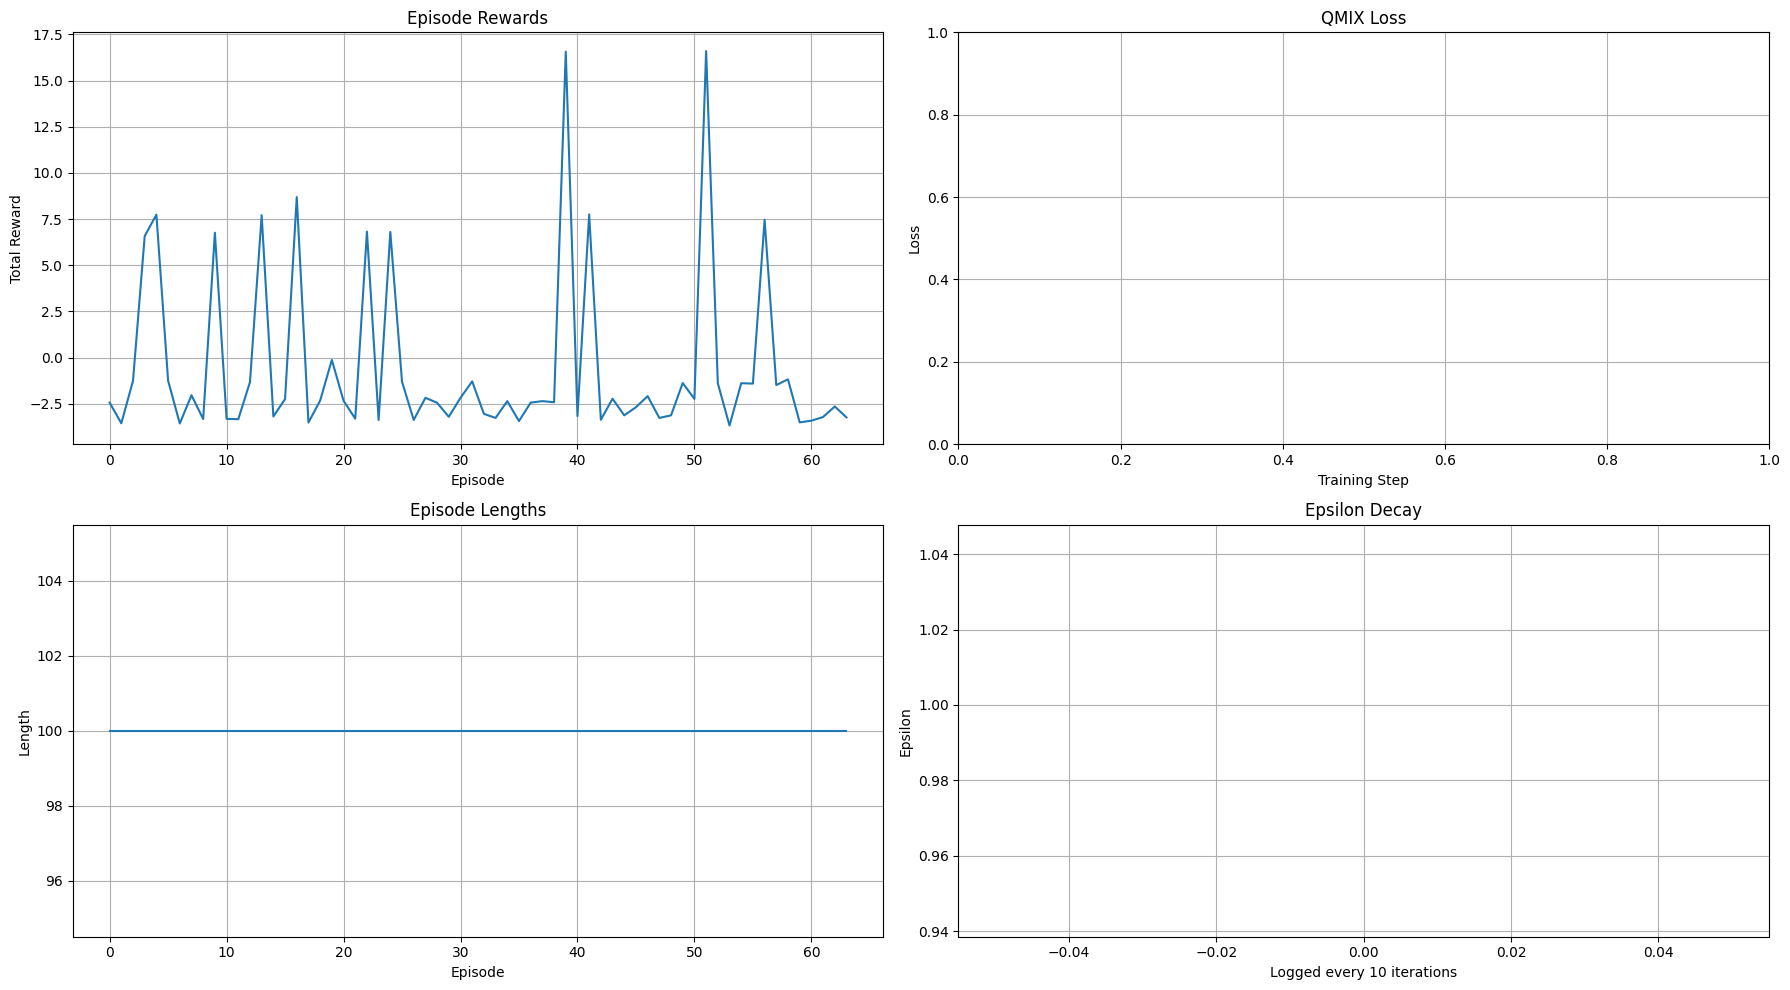

In [15]:
import pygame


args = Args() # Load hyperparameters
print("========== QMIX CONFIGURATION ==========")
for k, v in vars(args).items():
    print(f"{k}: {v}")
print("========================================")
print(f"Using device: {device}")
# --- Environment and Action Conversion Setup ---
MOVE_COST = args.move_cost if hasattr(args, "move_cost") else -0.01
DELIVERY_REWARD = args.delivery_reward if hasattr(args, "delivery_reward") else 10
DELAY_REWARD = args.delay_reward if hasattr(args, "delay_reward") else 1
SEED = args.seed if args.seed is not None else 42
NUM_ENVS = args.num_parallel_envs if hasattr(args, "num_parallel_envs") else 1
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

# Action conversion (environment uses string actions)
le_move = LabelEncoder()
le_move.fit(['S', 'L', 'R', 'U', 'D']) # Stay, Left, Right, Up, Down
le_pkg_op = LabelEncoder()
le_pkg_op.fit(['0', '1', '2']) # 0: None, 1: Pickup, 2: Drop
args.num_move_actions = len(le_move.classes_)
args.num_pkg_ops = len(le_pkg_op.classes_)
args.action_dim = args.num_move_actions * args.num_pkg_ops # Total discrete actions

# --- Determine Observation and State Shapes ---
print("Initializing temporary environment to get observation/state shapes...")
try:
    _temp_env = Environment(
        map_file=args.map_file,
        n_robots=args.n_agents,
        n_packages=args.n_packages,
        move_cost=MOVE_COST,
        delivery_reward=DELIVERY_REWARD,
        delay_reward=DELAY_REWARD,
        seed=SEED,
        max_time_steps=args.max_time_steps_env
    )
    temp_env_state_dict = _temp_env.reset() # Returns dict
    
    # Initialize persistent packages for the temp env for shape calculation
    temp_persistent_packages = {}

    _s_obs_example = convert_observation(temp_env_state_dict, temp_persistent_packages, 0)
    args.spatial_obs_shape = _s_obs_example.shape
    
    _v_obs_example = generate_vector_features(temp_env_state_dict, temp_persistent_packages, 0,
                                                args.max_time_steps_env, args.max_other_robots_to_observe,
                                                args.max_packages_to_observe)
    args.vector_obs_dim = _v_obs_example.shape[0]

    _gs_s_example, _gs_v_example = convert_global_state(temp_env_state_dict, temp_persistent_packages,
                                                        args.max_time_steps_env, args.max_robots_in_state,
                                                        args.max_packages_in_state)
    args.global_spatial_state_shape = _gs_s_example.shape
    args.global_vector_state_dim = _gs_v_example.shape[0]

    print(f"Spatial Obs Shape: {args.spatial_obs_shape}, Vector Obs Dim: {args.vector_obs_dim}")
    print(f"Global Spatial State Shape: {args.global_spatial_state_shape}, Global Vector State Dim: {args.global_vector_state_dim}")
    print(f"Action Dim: {args.action_dim}, Num Agents: {args.n_agents}")

except ImportError as e:
    print(f"Could not import environment for shape determination: {e}")
    exit()
except Exception as e:
    print(f"Error during temporary environment initialization or shape calculation: {e}")
    import traceback
    traceback.print_exc()
    exit()

# --- Initialize Learner and Replay Buffer ---
replay_buffer = ReplayBuffer(
    args.buffer_size, args.episode_limit, args.n_agents,
    args.spatial_obs_shape, args.vector_obs_dim,
    args.global_spatial_state_shape, args.global_vector_state_dim,
    args.action_dim, 
    args
)

# --- Vectorized Environment for Data Collection ---
print(f"Initializing {NUM_ENVS} parallel environments...")
try:
    vec_env = VectorizedEnv(
        Environment, num_envs=NUM_ENVS,
        map_file=args.map_file,
        n_robots=args.n_agents,
        n_packages=args.n_packages,
        move_cost=MOVE_COST,
        delivery_reward=DELIVERY_REWARD,
        delay_reward=DELAY_REWARD,
        seed=SEED,
        max_time_steps=args.max_time_steps_env
    )
except Exception as e:
    print(f"Failed to initialize VectorizedEnv: {e}. Ensure 'env.py' and 'env_vectorized.py' are correct.")
    exit()


try:
    # --- Initialize QMixLearner (New way) ---
    qmix_trainer = QMixLearner(
        n_agents=args.n_agents,
        action_dim=args.action_dim,
        args=args,
        vec_env=vec_env,
        replay_buffer=replay_buffer,
        le_move=le_move,
        le_pkg_op=le_pkg_op
    )

    # --- Training Loop ---
    total_timesteps_collected = 0
    total_episodes_collected = 0
    episode_rewards_history = []
    episode_lengths_history = []
    losses_history = []
    epsilon_history_log = [] # For logging epsilon at each action selection

    # Load model if specified
    if args.load_model_path and args.load_model_episode > 0:
        print(f"Loading model from {args.load_model_path} at episode {args.load_model_episode}...")
        qmix_trainer.load_models_learner(args.load_model_path, args.load_model_episode)

    print(f"Starting QMIX training on {device}...")

    qmix_trainer._initialize_collection_state(initial_reset=True) # Initial reset of envs and internal states

    # Main training iterations (each iteration collects data and potentially trains)
    for training_iteration in range(1, args.max_training_iterations + 1):
        
        # --- Data Collection Phase ---
        # Hidden states are reset inside collect_data_iteration for the new batch of episodes
        iter_timesteps, iter_episodes_info, iter_epsilon = \
            qmix_trainer.collect_data_iteration(total_timesteps_collected)

        total_timesteps_collected += iter_timesteps
        for ep_info in iter_episodes_info:
            total_episodes_collected += 1
            episode_rewards_history.append(ep_info['reward'])
            episode_lengths_history.append(ep_info['length'])
        
        if iter_epsilon is not None and training_iteration % args.log_interval == 0 :
            epsilon_history_log.append(iter_epsilon)


        # --- Training Phase ---
        if qmix_trainer.replay_buffer.can_sample() and \
        total_timesteps_collected > args.min_timesteps_to_train : # Ensure some initial exploration
            
            iter_losses = qmix_trainer.run_training_steps()
            losses_history.extend(iter_losses)

        # --- Logging and Saving ---
        if training_iteration % args.log_interval == 0:
            avg_reward = np.mean(episode_rewards_history[-args.log_interval*NUM_ENVS:]) if episode_rewards_history else 0
            avg_length = np.mean(episode_lengths_history[-args.log_interval*NUM_ENVS:]) if episode_lengths_history else 0
            avg_loss = np.mean(losses_history[-args.log_interval*NUM_ENVS*args.num_train_steps_per_iteration:]) if losses_history else 0 # Approx
            last_epsilon = epsilon_history_log[-1] if epsilon_history_log else args.epsilon_start
            
            print(f"Iter: {training_iteration}/{args.max_training_iterations} | Total Timesteps: {total_timesteps_collected} | Total Episodes: {total_episodes_collected}")
            print(f"  Avg Reward (last {args.log_interval*NUM_ENVS} eps): {avg_reward:.2f} | Avg Length: {avg_length:.2f}")
            print(f"  Avg Loss (approx): {avg_loss:.4f} | Epsilon: {last_epsilon:.3f}")
            print(f"  Buffer Size: {len(qmix_trainer.replay_buffer)}/{args.buffer_size}")

        if training_iteration > 0 and training_iteration % args.save_model_interval == 0:
            print(f"Saving model at iteration {training_iteration}, episode {total_episodes_collected}...")
            qmix_trainer.save_models_learner(f"models/qmix_iter{training_iteration}", total_episodes_collected)

        if total_timesteps_collected >= args.max_total_timesteps:
            print(f"Reached max training timesteps: {args.max_total_timesteps}.")
            break
except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc()
finally:
    pygame.quit()
    # --- End of Training Loop ---
    print("Training finished.")
    qmix_trainer.save_models_learner("models/qmix_final", total_episodes_collected)

    # --- Plotting ---
    if not os.path.exists("plots"): os.makedirs("plots")
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 2, 1)
    if episode_rewards_history:
        plt.plot(episode_rewards_history)
        # Moving average
        if len(episode_rewards_history) >= 100:
            rewards_moving_avg = np.convolve(episode_rewards_history, np.ones(100)/100, mode='valid')
            plt.plot(np.arange(99, len(episode_rewards_history)), rewards_moving_avg, label='100-ep MA')
            plt.legend()
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    if losses_history:
        plt.plot(losses_history)
    plt.title('QMIX Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    if episode_lengths_history:
        plt.plot(episode_lengths_history)
    plt.title('Episode Lengths')
    plt.xlabel('Episode')
    plt.ylabel('Length')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    if epsilon_history_log: 
        plt.plot(epsilon_history_log)
        plt.title('Epsilon Decay')
        plt.xlabel(f'Logged every {args.log_interval} iterations')
        plt.ylabel('Epsilon')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig("plots/qmix_training_plots.png")
    print("Training plots saved to plots/qmix_training_plots.png")
    plt.show()